# Initial setups

## Imports and structs

In [1]:
using JuMP
using Gurobi
env = Gurobi.Env()
using PowerSystems

using CSV

using Graphs
using MetaGraphsNext
using CairoMakie
using GraphMakie
using SparseArrays
using GraphMakie.NetworkLayout

import LaTeXStrings

CairoMakie.activate!(type = "svg")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27


In [2]:
mutable struct Branch
    b::Float64
    p_max::Float64
    v_nom1::Float64
    v_nom2::Float64
    p::Float64
    outage::Bool
    trip::Bool
    Branch(b, p_max) = new(b, p_max, 0, 0, 0, false, false)
    Branch(b, p_max, v_nom1, v_nom2) = new(b, p_max, v_nom1, v_nom2, 0, false, false)
    Branch(b::Branch) = new(b.b, b.p_max, b.v_nom1, b.v_nom2, b.p, false, false)
    Branch(b::Branch, p_max) = new(b.b, p_max, b.v_nom1, b.v_nom2, b.p, false, false)
end

struct BranchId
    bus1::Int64
    bus2::Int64
end

In [3]:
mutable struct SubBus
    p::Float64
    branch_ids::Vector{Int8}
end

mutable struct BusConf
    bus::Int16
    subBuses::Vector{SubBus}
end

## Utility functions

## Graph

In [4]:
e_index_for(g::MetaGraph, e::Graphs.SimpleEdge) = g[label_for(g,src(e)), label_for(g,dst(e))]

e_index_for (generic function with 1 method)

In [5]:
function add_subBus(g::MetaGraph, busconfs::Vector{BusConf})
    h=deepcopy(g)
    e_labels = collect(edge_labels(h))
    for bc in busconfs
        bc_bus_label = label_for(g, bc.bus)
        # Map the branches of the subBus
        sb2edges = Dict(sb => [e_labels[br] for br in sb.branch_ids] for sb in bc.subBuses)
        edges_origin = collect(edges(h))
        edges_to_remove = [edges_origin[br] for sb in bc.subBuses for br in sb.branch_ids]
        for e in edges_to_remove
            rem_edge!(h, src(e), dst(e))
        end

        # Build the new bus and connect the branches
        for (i, sb) in enumerate(bc.subBuses)
            #create the new vertex
            new_v_label = "$(bc_bus_label)-$i"
            h[new_v_label] = sb.p
            h[bc_bus_label] = h[bc_bus_label] - sb.p
            # connect the copy of the branches
            for br in sb2edges[sb]
                new_e_label = br[1] == bc_bus_label ? (new_v_label, br[2]) : (br[1], new_v_label)
                h[new_e_label...] = g[br...]
            end
        end
    end
    h
end

add_subBus (generic function with 1 method)

### Minigrid

In [6]:
function build_simple_grid(;micro = true)
    g = MetaGraph(
        DiGraph();
        label_type=String,
        vertex_data_type = Float64,
        edge_data_type = Branch,
    )
    g["1"] = micro ? -2 : -3
    for i=2:(micro ? 3 : 4)
        g["$i"] = 1
    end
    g["1","2"] = Branch(1, 1)
    g["2","3"] = Branch(1, 1)
    if micro
        g["1","3"] = Branch(1,1)
    else
        g["3","4"] = Branch(1, 1)
        g["2","4"] = Branch(1, 1)
        g["1","4"] = Branch(1, 1)
    end
    g
end


build_simple_grid (generic function with 1 method)

### Parse MatPower files

In [7]:
function network2graph(sys::System, v=false)
    g = MetaGraph(
        DiGraph();
        label_type=String,
        vertex_data_type = Float64,
        edge_data_type = Branch,
    )

    init_p_bus(g, sys, objType, op) = 
        for k in get_components(objType, sys)
            v && println("bus $(k.bus.number)\t$(repr(op)) $(k.active_power)")
            g["$(k.bus.number)"] = op(haskey(g,"$(k.bus.number)") ? g["$(k.bus.number)"] : 0, k.active_power)
        end
    init_p_bus(g, sys, PowerLoad, +)
    init_p_bus(g, sys, Generator, -)
    
    v && println("branches")
    for k in get_components(ACBranch, sys)
        if !haskey(g, "$(k.arc.from.number)")
            v && println("bus: $(k.arc.from.number)")
            g["$(k.arc.from.number)"] = 0
        end
        if !haskey(g, "$(k.arc.to.number)")
            v && println("bus: $(k.arc.to.number)")
            g["$(k.arc.to.number)"] = 0
        end
        v && println("(\"$(k.arc.from.number)\", \"$(k.arc.to.number)\") ")
        g["$(k.arc.from.number)", "$(k.arc.to.number)"] = Branch(1/k.x, 10, k.arc.from.base_voltage, k.arc.to.base_voltage)
    end
    
    to_remove = []
    for node in vertices(g)
        if isempty(inneighbors(g,node)) && isempty(outneighbors(g,node))
            push!(to_remove, label_for(g,node))
        end
    end
    v && !isempty(to_remove) && println("\nremove nodes: $to_remove")

    foreach(node-> rem_vertex!(g, code_for(g,node)), to_remove)
    
    g
end

network2graph (generic function with 2 methods)

In [8]:
function balance!(g)
    non_zeros = [label for label in labels(g) if g[label] ≠ 0]
    imbalance = sum(g[label] for label in non_zeros) / length(non_zeros)
    for label in non_zeros
        g[label] -= imbalance
    end
end

balance! (generic function with 1 method)

In [9]:
function check_flow_consistency(g; v::Bool=false)
    flows = Dict(l => g[l...].p for l in edge_labels(g))
    injections = Dict(l => g[l] for l in labels(g))

    # Initialize net flows for each node
    net_flows = Dict{String, Float64}()

    # Update net flows based on branch flows
    for ((from, to), flow) in flows
        net_flows[from] = get(net_flows, from, 0.0) - flow
        net_flows[to] = get(net_flows, to, 0.0) + flow
    end

    # Compare with injections
    consistent = true

    v && println("\nComparison with injections:")
    for (node, injection) in injections
        net_flow = get(net_flows, node, 0.0)

        v && println("Node $node: Injection = $injection, Net Flow = $net_flow, Difference = $(injection - net_flow)")
        if abs(injection - net_flow) > 1e-9  # Tolerance for floating-point comparison
            consistent = false
        end
    end

    if v
        if consistent
            println("\nThe flows and injections are consistent.")
        else
            println("\nThe flows and injections are not consistent.")
        end
    end
    consistent
end

check_flow_consistency (generic function with 1 method)

### Tune the grid with constraints - indicators on OTS results

In [10]:
add_constraint(g, fun) = foreach(e -> fun(e_index_for(g,e)), edges(g))

set_limitations(branches, lim) = Dict( k => begin
        br_out = Branch(br_in, br_in.v_nom1 == 138.0 ? lim : 10)
    end for (k,br_in) in branches)

function indicators(model)
    sw = [s for s in model[:sw] if value(s) == 0.0]
    ls = [l for l in model[:ls] if value(l) ≠ 0.0]
    sw, ls
end

indicators (generic function with 1 method)

### LaTeX

In [11]:
function filter_latex_formulation(model, word)
    lf = repr(latex_formulation(model))
    word == "" && return LaTeXStrings.LaTeXString(lf)
    splited = split(lf ,"\n")
    filtered = join(filter(line-> occursin(word, line), splited), "\n")
    joined = join(["\\begin{aligned}", filtered
                , "\\end{aligned}"], " ")
    LaTeXStrings.LaTeXString(joined)
end

filter_latex_formulation (generic function with 1 method)

## Drawing

In [12]:
"""
    generate_csv(Dict{String, Point2}) -> String
    
Generates a String that represents a CSV file from the dict of Points
"""
function generate_csv(dic)
    println("bus_i,x,y")
    foreach(l->println("$l, $(dic[l][1]), $(dic[l][2])"), sort(collect(keys(dic)), by=x-> parse(Int, x)))
end

generate_csv

In [13]:
"""
    load_coord(filename) -> Dict{String, Point2}

Load a csv file containing the coordinates
"""
function load_coord(file)
    csv_data = CSV.File(file)
    coord = Dict{String, Point2}()
    foreach(row -> coord["$(row.bus_i)"] = Point(row.x, row.y), csv_data)
    coord
end

load_coord

In [14]:
function complete_subBus_coords(g, init_points)
    res_points = Point2[]
    for lab in labels(g)
        if haskey(init_points, lab)
            push!(res_points, init_points[lab])
        else
            neighbs = [label_for(g, c) for c in all_neighbors(g, code_for(g, lab))]
            push!(neighbs, split(lab, "-")[1])
            push!(res_points, 1/length(neighbs) * reduce(+, [init_points[lab] for lab in neighbs]))
        end
    end
    res_points
end

complete_subBus_coords (generic function with 1 method)

In [15]:
function draw(g_orig::MetaGraph;

                outages = [],
                trip = nothing,
    
                fig_size = (900, 600),
                font_size = 15,
                layout = Stress(Ptype=Float32),
                margin_ratio =7,
                digits = 2,
    
                node_label = (g, label; digits = 2) -> "$label($(round(g[label], digits=digits)))",
                marker = (g, label) -> g[label]>=0 ? :rect : :circle,
                node_size = (g, label, max_p) -> sqrt(abs(g[label]))/sqrt(max_p)*80,

                edge_labels = (br; digits = 2) -> repr(round(br.p, digits=digits)),
                edge_coloring = (br; tol=1e-6) -> br.outage ? :black : (abs(br.p>br.p_max + tol) ? :red : :green),
                edge_style = branch -> branch.trip ? :dot : :solid,
                edge_width = 3,
                arrow_size = 25,
                )

    g = copy(g_orig)
    max_p = maximum(collect(labels(g)) .|> l->abs(g[l]))
    gLabels = [label_for(g, v) for v in vertices(g)]
    to_reverse = []
    for (i,e) in enumerate(edges(g))
        br = e_index_for(g, e)
        if i in outages
            br.outage = true
        end
        if i == trip
            br.trip = true
        end
        if br.p<0
            push!(to_reverse, e)
        end
    end
    for e in to_reverse
        b = e_index_for(g, e)
        b.p = -b.p
        rem_edge!(g, src(e), dst(e))
        g[label_for(g,dst(e)), label_for(g,src(e))] = b
    end

    fig = Figure(size = fig_size, fontsize = font_size)
    ax = Axis(fig[1, 1])

    x_min, x_max, y_min, y_max = reduce(((x_min, x_max, y_min, y_max), pt) 
        -> (min(pt[1], x_min), max(pt[1], x_max), min(pt[2], y_min), max(pt[2], y_max)), 
        layout isa Dict{String, Point2} ? values(layout) : layout(g) , init = (0,0,0,0))
    delta_x, delta_y = ((x_max - x_min) , (y_max - y_min)) ./ margin_ratio
    xlims!(ax, x_min-delta_x, x_max+delta_x)
    ylims!(ax, y_min-delta_y, y_max+delta_y)
    
    g_labels = [label_for(g, v) for v in vertices(g)]
    branches = [e_index_for(g, e) for e in edges(g)]

    graphplot!(ax, g;
        layout = layout isa Dict{String, Point2} ? complete_subBus_coords(g, layout) : layout,
        node_size = [node_size(g, l, max_p) for l in gLabels],
        node_attr = (marker = [marker(g, l) for l in g_labels], color= :white, strokecolor = :red, strokewidth = 3,),
        nlabels = [node_label(g, l, digits=digits) for l in g_labels],
        elabels = [edge_labels(b, digits=digits) for b in branches],
        edge_plottype = :beziersegments,
		edge_attr = (linestyle = [edge_style(b) for b in branches],),
        edge_color = [edge_coloring(b) for b in branches],
        edge_width = edge_width,
        arrow_size = arrow_size,
        arrow_shift = :end,
        )
    hidedecorations!(ax)
    hidespines!(ax)

    ax.aspect = DataAspect()
    display(fig)
    fig
end

draw (generic function with 1 method)

# Models

## DC-PF with linear algebra

In [16]:
function dc_flow!(g; outages = [], trip = nothing)
    A = incidence_matrix(g; oriented = true)'
    for outage in outages
        A[outage,:] .= 0
    end
    if trip ≠ nothing
        A[trip,:] .= 0
    end
    D = spdiagm([e_index_for(g,e).b for e in edges(g)])
    B = A'*D*A
    B_inv = inv(Matrix(B + fill(1/nv(g), nv(g), nv(g))))
    p_to_f = D*A*B_inv
    flows = p_to_f * [g[label_for(g, v)] for v in vertices(g)]
    for (i,e) in enumerate(edges(g))
        e_index_for(g, e).p = flows[i]
    end
    g
end

function dc_flow(g; outages = [], trip = nothing)
    h=deepcopy(g)
    dc_flow!(h, outages = outages, trip = trip)
end


dc_flow (generic function with 1 method)

## Secured DC PF

$$ \rho^* = {\arg\,\min_{\rho, \vec{f}}}\, \rho\\
s.t.\\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p}\\
|\vec{f}| \preceq \rho \overline{\vec{f}}$$

$$ \rho^* = \arg\,\min_{\rho, \vec{f}}\,\max_{\vec{\beta},\vec{u}}\, \rho\\
s.t.\\
\vec{f_i} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})\vec{\beta}\\
|\vec{f}| \preceq \rho \overline{\vec{f}}$$

ie with $ dim(\vec{u}) = dim(\vec{\beta}) = dim(\vec{\alpha})$
$$ \rho^* = \arg\,\min_{\rho}\, \rho \\
s.t. \\
\vec{F_i} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})\vec{\beta_i} \ \forall i\\
\rho \ge \alpha_i \ \forall i\\
|\vec{F_i}| \preceq \alpha_i \overline{\vec{f}} \ \forall i \\
0 \preceq \vec{\alpha} \preceq \vec{u}M \\
|\vec{f}| \preceq (1-\vec{u})M \\
|\vec{\beta}| \preceq \vec{u}M \\
u_l \in \{0,1\} \\
\sum_l{u_l} \le 1
$$


In [17]:
function create_dc_matrix(g)
    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)])
    B = A'*D*A
    B_inv = inv(Matrix(B + fill(1/nv(g), nv(g), nv(g))))
    p_to_f = D*A*B_inv
    δ_to_f = D - p_to_f*A'*D
    A, D, B_inv, p_to_f, δ_to_f
end

create_dc_matrix (generic function with 1 method)

In [18]:
function secured_dc_pf_optim(g, contingencies)
    model = direct_model(Gurobi.Optimizer())
    set_silent(model)

    A, D, B_inv, p_to_f, δ_to_f = create_dc_matrix(g)

    big_M = 100

    p = [g[label_for(g, v)] for v in vertices(g)]
    p_max = [e_index_for(g, e).p_max for e in edges(g)]
    
    outages = collect(contingencies)
    push!(outages, 0)
    nb_c = length(outages)

    @variable(model, β[1:nb_c, 1:ne(g)])
    @constraint(model, [i=1:nb_c],  β[i,:] .≤ [j==outages[i] ? big_M : 0 for j in 1:ne(g)])
    @constraint(model, [i=1:nb_c], -β[i,:] .≤ [j==outages[i] ? big_M : 0 for j in 1:ne(g)])

    @variable(model, flows[1:nb_c, 1:ne(g)])
    @constraint(model, [i=1:nb_c], flows[i,:] .== p_to_f * p + δ_to_f * β[i,:])
    @constraint(model, [i=1:nb_c-1], flows[i, outages[i]] == 0) # i=nb_c : base case
    
    @variable(model, α[1:nb_c])
    @constraint(model, [i=1:nb_c], flows[i,:] .≤ α[i].*p_max)
    @constraint(model, [i=1:nb_c], -α[i].*p_max .≤ flows[i,:])

    @variable(model, α_max)
    @constraint(model, [i=1:nb_c], α .≤ α_max)

    @objective(model, Min, α_max)
    model
end

secured_dc_pf_optim (generic function with 1 method)

## Secured DC OTS

With $\mathcal{C}$ the set of contingencies, $\mathcal{V}$ the set of edges and $\mathcal{E}$ the set of edges.

$$
\begin{split}
    \rho^* = \arg\,\min_{\pmb{\gamma},\vec{v}, \pmb{\beta}, \pmb{f}, \rho}\, & \rho +\alpha \sum_{e \in \mathcal{E}}{v_e}\\
    s.t.\\
    \vec{f_c} = \pmb{DA\hat{B}^{-1}} \vec{p} + (\pmb{D - DA\hat{B}^{-1}A^TD})(\vec{\beta_c} + \vec{\gamma_c}) & \quad \forall c \in \mathcal{C} \\
    |\vec{f_c}| \preceq \rho \overline{\vec{f_c}} & \quad \forall c \in \mathcal{C} \\
    (1-\vec{v}) \odot \vec{\gamma_c} = 0 & \quad \forall c \in \mathcal{C} \\
    \beta_{c, e} = 0 & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E}\ |\ c\ne e \\
    v_{e} \in \{0,1\} & \quad \forall e \in \mathcal{E} \\
\end{split}
$$

The cost function is the weighted sum of the maximum overload and the sum of line openings. The later term reduces the number of line openings, the weight $\alpha$ can be pretty low so that it does not impede the main cost.

A lower bound can be set on the overload so that $\rho \ge \rho\_min\_bound$ (the default value is 0). Thus, when a line is below this bound, no measure is to be taken. A bound set to 1 implies the operational limits are targeted.

A variant of the first term ($is\_single\_\rho = false$) consists in minimizing the sum of $\rho_e - \rho\_min\_bound \, \forall e \in \mathcal{E}$ over all the line. This allows to not only focus on the most loaded line, but to takes into account all the line above the threshold. 

Ensuring connectedness using a fictitious mirror graph with variables $\star$, having with the same switching and 1 source bus is injecting $|\mathcal{V}| - 1$ (no unit as it is fictitious injection), and each of the others is withdrawing $1$, which ensures there is a connected path from any of them to the source bus. This is done for all the contingencies. 

$$
\begin{split}
\overrightarrow{f^\star_{c}} \odot (1-\overrightarrow{u_c}) = 0 & \quad \forall c \in \mathcal{C} \\
\overrightarrow{f^\star_{c}} \odot (1-\overrightarrow{v}) = 0 & \quad \forall c \in \mathcal{C} \\
(f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}) * u_{c,e} = 0 & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
(f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}) * v_e = 0 & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
p^\star_i = \sum_{e \in \mathcal{E}|dst(e)=i}{f^\star_{c,e}} - \sum_{e \in \mathcal{E}|src(e)=i}{f^\star_{c,e}}  & \quad \forall (c, i) \in \mathcal{C}\times\{1..|\mathcal{V}|\} \\
p^\star_i  = 1 & \quad \forall i \in \{1..|\mathcal{V}| - 1\} \\
p^\star_n = - (|\mathcal{V}| - 1) \\
\end{split}
$$

Which translates into:
$$
\begin{split}
|\overrightarrow{f^\star_{c}}| \le M * (1-\overrightarrow{u_c}) & \quad \forall c \in \mathcal{C} \\
|\overrightarrow{f^\star_{c}}| \le M * (1-\overrightarrow{v}) & \quad \forall c \in \mathcal{C} \\
|f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}|  \le M * u_{c,e} & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
|f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}|  \le M * v_e & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
p^\star_i = \sum_{e|dst(e)=i}{f^\star_{c,e}} - \sum_{e|src(e)=i}{f^\star_{c,e}}  & \quad \forall (c, i) \in \mathcal{C}\times\{1..|\mathcal{V}|\} \\
p^\star_i  = 1 & \quad \forall i \in \{1..|\mathcal{V}| - 1\} \\
p^\star_n = - (|\mathcal{V}| - 1) \\
\end{split}
$$

A void contingency is added to take the base case into consideration, and the parameter $n\_1\_connectedness$ ($true$ by default)can be set to $false$ if the connectedness is not to be considered in N-1.

In [19]:
function secured_dc_OTS(g::MetaGraph;
                                    contingencies::Vector{Int} = Int[],
                                    is_single_ρ::Bool=true,
                                    ρ_min_bound::Float64 = 0.,
                                    n_1_connectedness::Bool = true,
                                    bus_confs::Vector{BusConf} = BusConf[],
                                    allow_branch_openings::Bool = true)

    model = direct_model(Gurobi.Optimizer())
    # set_silent(model)
    set_optimizer_attribute(model, "LogFile", "my_log_file.txt")

    A, D, B_inv, p_to_f, δ_to_f = create_dc_matrix(g)
    big_M = 100

    p = [g[label_for(g, v)] for v in vertices(g)]
    p_max = [e_index_for(g, br).p_max for br in edges(g)]
    
    # function that returns the bus on the side of the edge
    branch_side2bus(br, side) = findfirst(i-> A[br,i] == (side == 1 ? -1 : 1), 1:nv(g))
    branch_bus2side(br, v) = A[br,v] == 1 ? 2 : -A[br,v]

    outages = collect(contingencies)
    push!(outages, 0)
    nb_cases = length(outages)

    # case i, branch j is open if outages[i]==1
    is_outage(i,j) = j == outages[i] ? 1 : 0

    # bus configuration utils
    allow_bus_splitting = !isempty(bus_confs)
    nb_bus_confs = length(bus_confs)

    bus_to_conf = reduce((acc, (index, conf)) -> (
                push!(get!(acc, conf.bus, Vector{Int}()), index);
                acc
            ), enumerate(bus_confs),
            init = Dict(i => Int[] for i in 1:nv(g))
        )

    branch_to_confs = reduce((acc, (index, conf)) -> (
                for br in (br for sb in conf.subBuses for br in sb.branch_ids)
                    push!(get!(acc, br, Vector{Int}()), index)
                end;
                acc
                ), enumerate(bus_confs),
            init = Dict(i => Int[] for i in 1:ne(g))
        )

    @variable(model, flows[1:nb_cases, 1:ne(g)])

    if allow_branch_openings
        @variable(model, v_branch[1:ne(g)], Bin)
        @variable(model, γ_branch[1:nb_cases, 1:ne(g)])

        @constraint(model, [i=1:nb_cases],  γ_branch[i,:] .≤ v_branch .* big_M)
        @constraint(model, [i=1:nb_cases], -γ_branch[i,:] .≤ v_branch .* big_M)

        @constraint(model, [i=1:nb_cases],  flows[i,:] .≤ (1 .- v_branch) .* big_M)
        @constraint(model, [i=1:nb_cases], -flows[i,:] .≤ (1 .- v_branch) .* big_M)

    end

    @variable(model, v_bus[1:nb_bus_confs], Bin)
    @variable(model, γ_bus[1:nb_cases, k=1:nb_bus_confs])

    @constraint(model, [i=1:nb_cases, 1:nb_bus_confs],  γ_bus[i, :] .≤ v_bus[:] .* big_M)
    @constraint(model, [i=1:nb_cases, 1:nb_bus_confs], -γ_bus[i, :] .≤ v_bus[:] .* big_M)

    @variable(model, -big_M .≤ β[1:nb_cases] .≤ big_M) #TODO: \beta[nb_cases] should be null
    @constraint(model, [i=1:nb_cases-1], flows[i, outages[i]] == 0)  # nb_cases is the index of the base case

    bus_conf2branches = Dict(bc => [br for sb in bc.subBuses for br in sb.branch_ids] for bc in bus_confs) 

    @constraint(model, [i=1:nb_cases],
                            flows[i,:] .== p_to_f * p + δ_to_f *
                                (
                                   β[i] .* [is_outage(i,j) for j=1:ne(g)] 
                                .+ (allow_branch_openings ? γ_branch[i,:] : 0)
                                .+ (allow_bus_splitting ? 
                                        [sum(br in sb.branch_ids ? (A[br, bus_confs[k].bus] * γ_bus[i, k]) : 0
                                            for k=1:nb_bus_confs for sb in bus_confs[k].subBuses ) 
                                            for br = 1:ne(g)]
                                    : 0)
                                )
                )

    for (k, bus, sb) in ((k, bc.bus, sb) for (k, bc) in enumerate(bus_confs) for sb in bc.subBuses)
        @constraint(model, [i=1:nb_cases],
          sum(flows[i, br] * A[br, bus] for br in sb.branch_ids) - sb.p  ≤ (1 - v_bus[k]) * big_M)
        @constraint(model, [i=1:nb_cases], 
        -(sum(flows[i, br] * A[br, bus] for br in sb.branch_ids) - sb.p) ≤ (1 - v_bus[k]) * big_M)
    end

    # overload is the value to be minimized. It relies on ρ which is flow/flow_limit - ρ_min_bound.
    # ρ_min_bound=1 if the expectation is to get a situation without overload.
    # It can be either the max of load over all the branches (is_single_ρ)
    # or it can be the sum of the of all the over the min_bound load.
    @variable(model, overload)
    if is_single_ρ
        @variable(model, ρ ≥ ρ_min_bound)
        @constraint(model, overload == ρ - ρ_min_bound)
    
        @constraint(model, [i=1:nb_cases], flows[i,:] .≤ ρ.*p_max)
        @constraint(model, [i=1:nb_cases], -ρ.*p_max  .≤ flows[i,:])
    else
        @variable(model, ρ[1:ne(g)] ≥ 0)
        @constraint(model, overload == sum(ρ))
    
        @constraint(model, [i=nb_cases], flows[i,:] .≤ (ρ .+ ρ_min_bound).*p_max)
        @constraint(model, [i=nb_cases], -(ρ .+ ρ_min_bound).*p_max .≤ flows[i,:])
    end

    # connectivity constraints
    nb_bus_tot = nv(g) + sum(length(bus_to_conf[bus]) for bus in 1:nv(g))
    big_M2 = nb_bus_tot
    first = n_1_connectedness ? 1 : nb_cases        # nb_cases is the index of the base case

    # c_φ corresponds to the phase angle for source (1) and destination (2) of edges
    # c_Φ_base corresponds to the phase of the bus in the case all lines of the substation are connected
    @variable(model, c_φ[first:nb_cases, 1:ne(g), 1:2])
    @variable(model, c_flows[first:nb_cases, 1:ne(g)])
    @variable(model, c_Φ_base[first:nb_cases, 1:nv(g)])
    @variable(model, c_Φ_split[first:nb_cases, 1:nb_bus_confs])
    
    # the flow in the branch equals the angle difference between the terminals
    @constraint(model, [i=first:nb_cases, j=1:ne(g)], c_flows[i,j] == c_φ[i,j,2] - c_φ[i,j,1])

    # c_w = max(is_outage, v_branch) == 1 if the corresponding branch is not connected to the base bus either by outage or line opening or bus splitting, ie c_w is ≤ 1, ≥ each of them, and ≤ the sum of them.
    @variable(model, c_w[first:nb_cases, 1:ne(g), 1:2])
    if allow_branch_openings
        @constraint(model, [i=first:nb_cases, j=1:ne(g), s=1:2], c_w[i, j, s] ≥ is_outage(i,j))
        @constraint(model, [i=first:nb_cases, j=1:ne(g), s=1:2], c_w[i, j, s] ≥ v_branch[j])
        @constraint(model, [i=first:nb_cases, j=1:ne(g), s=1:2], c_w[i, j, s] ≤ is_outage(i,j) + v_branch[j])
    else 
        @constraint(model, [i=first:nb_cases, j=1:ne(g), s=1:2], c_w[i, j, s] == is_outage(i,j))
    end
    
    # when a bus split is activated, then, the bus angle of the branch corresponds to the one of the new bus
    for (k, bus, br) in [(k, bc.bus, br) for (k, bc) in enumerate(bus_confs) for sb in bc.subBuses for br in sb.branch_ids]
        side = branch_bus2side(br, bus)
        @constraint(model, [first:nb_cases],   c_φ[:, br, side] .- c_Φ_split[:, k]  .≤ big_M2 * (1 - v_bus[k]))
        @constraint(model, [first:nb_cases], -(c_φ[:, br, side] .- c_Φ_split[:, k]) .≤ big_M2 * (1 - v_bus[k]))
    end

    # terminal and bus angles are identical when the line is connected to the bus, which is the case when c_w==0 but not the case when the bus is split
    @constraint(model, [first:nb_cases, br=1:ne(g), s=1:2],
          c_φ[:, br, s] .- c_Φ_base[:, branch_side2bus(br, s)] 
            .≤ big_M2 .* (c_w[:, br, s] 
            .+ sum([v_bus[k] for k in filter(conf_id -> branch_bus2side(br, bus_confs[conf_id].bus) == s,
                                            branch_to_confs[br])])))
    @constraint(model, [first:nb_cases, br=1:ne(g), s=1:2],
        -(c_φ[:, br, s] .- c_Φ_base[:, branch_side2bus(br, s)])
            .≤ big_M2 .* (c_w[:, br, s] 
            .+ sum([v_bus[k] for k in filter(conf_id -> branch_bus2side(br, bus_confs[conf_id].bus) == s,
                                            branch_to_confs[br])])))
    
    # c_flows are null when a line is open : c_w == 1
    @constraint(model, [i=first:nb_cases, j=1:ne(g), s=1:2],  c_flows[i, j] ≤ big_M2 * (1 - c_w[i, j, s]))
    @constraint(model, [i=first:nb_cases, j=1:ne(g), s=1:2], -c_flows[i, j] ≤ big_M2 * (1 - c_w[i, j, s]))

    # the first bus holds a generator with n_bus_tot - 1 ( - its number of confs), each other consumes 1 + the number of confs
    @constraint(model, [i=first:nb_cases, bus = 1:nv(g)], 
        (bus == 1 ? -nb_bus_tot : 0) + 1 + length(bus_to_conf[bus])
        - sum(c_flows[i, br] * A[br, bus] for br in 1:ne(g)) 
        == 0)
    
    # the load of the new bus is equal to 1 if it is activated i.e. v_bus == 1, and is balanced with the flows on the corresponding lines
    for (k, bc) in enumerate(bus_confs)
        @constraint(model, [i=first:nb_cases], 
              1 - sum(c_flows[i, br] * A[br, bc.bus] for sb in bc.subBuses for br in sb.branch_ids)
                ≤ big_M2 * (1 - v_bus[k]))
        @constraint(model, [i=first:nb_cases], 
            -(1 - sum(c_flows[i, br] * A[br, bc.bus] for sb in bc.subBuses for br in sb.branch_ids))
                ≤ big_M2 * (1 - v_bus[k]) )
        end

    @objective(model, Min,
                overload 
                + 0.1  * (allow_branch_openings ? sum(v_branch) : 0) 
                + 0.01 * (allow_bus_splitting   ? sum(v_bus)    : 0) )
    model
end

secured_dc_OTS (generic function with 1 method)

In [20]:
function create_mini_case()
    mini_conf = [BusConf(2, [SubBus(1, [1])])]
    g = build_simple_grid(micro=false)
    g["1","4"].p_max = 2
    contingencies = []
    g, mini_conf, contingencies
end

create_mini_case (generic function with 1 method)

In [21]:
loadcase(case) = System(joinpath("data", "$case.m")), load_coord(joinpath("coord", "$case.csv"))

function create_case(sys=sys)
    g = network2graph(sys)
    balance!(g)
    add_constraint(g, b->b.p_max=1)
    bus_confs = [
                    BusConf(6, [SubBus(-.17 , [7, 9])])]
            # SubBus(0    , [9, 12]) ])]
#     BusConf(2,
#             [SubBus(0.076, [16, 1]),
#              SubBus(0    , [13, 7]) ]),
#                  ]
    # contingencies = [1, 3, 4, 6, 7, 9, 10, 11, 13, 14, 15]
    # contingencies = [11, 6, 3, 10, 15, 4, 2, 5]
    # contingencies = [1, 14]
    # contingencies = [12]
    contingencies = [1, 14, 15]

    # case14
    # g["1","5"].p_max = 2
    g, bus_confs, contingencies
    # g, BusConf[], contingencies, coord_30
    # g, BusConf[], contingencies, nothing
end

create_case (generic function with 2 methods)

In [22]:
sys, coord = loadcase("case14")

┌ Info: this code only supports angmin values in -90 deg. to 90 deg., tightening the value on branch 4 from -360.0 to -60.0 deg.
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/data.jl:1055
┌ Info: this code only supports angmax values in -90 deg. to 90 deg., tightening the value on branch 4 from 360.0 to 60.0 deg.
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/data.jl:1066
┌ Info: this code only supports angmin values in -90 deg. to 90 deg., tightening the value on branch 1 from -360.0 to -60.0 deg.
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/data.jl:1055
┌ Info: this code only supports angmax values in -90 deg. to 90 deg., tightening the value on branch 1 from 360.0 to 60.0 deg.
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/data.jl:1066
┌ Info: this code only supports angmin values in -90 deg. to 90 deg., ti

(System(PowerLoad(bus14, true, ACBus(14, Bus 14    LV, ACBusTypes.PQ = 1, -0.27995081201989047, 1.036, (min = 0.94, max = 1.06), 0.0, Area(1, 0.0, 0.0, 0.0), LoadZone(1, 2.59, 0.735), Dict{String, Any}()), 0.149, 0.05, 100.0, 0.149, 0.05, Service[], nothing, Dict{String, Any}())
PowerLoad(bus5, true, ACBus(5, Bus 5     HV, ACBusTypes.PQ = 1, -0.15323990832510212, 1.02, (min = 0.94, max = 1.06), 0.0, Area(1, 0.0, 0.0, 0.0), LoadZone(1, 2.59, 0.735), Dict{String, Any}()), 0.076, 0.016, 100.0, 0.076, 0.016, Service[], nothing, Dict{String, Any}())
PowerLoad(bus6, true, ACBus(6, Bus 6     LV, ACBusTypes.PV = 2, -0.24818581963359368, 1.07, (min = 0.94, max = 1.06), 0.0, Area(1, 0.0, 0.0, 0.0), LoadZone(1, 2.59, 0.735), Dict{String, Any}()), 0.11199999999999999, 0.075, 100.0, 0.11199999999999999, 0.075, Service[], nothing, Dict{String, Any}())
PowerLoad(bus12, true, ACBus(12, Bus 12    LV, ACBusTypes.PQ = 1, -0.2630211182755455, 1.055, (min = 0.94, max = 1.06), 0.0, Area(1, 0.0, 0.0, 0.0), L

"overload: 1.2273278964815704"

"open:Int64[]"

Any[]

"v_bus: [1.0]"

"γ_bus: [0.20887814463754217;;]"

"applied_conf: BusConf[BusConf(6, SubBus[SubBus(-0.17, Int8[7, 9])])]"

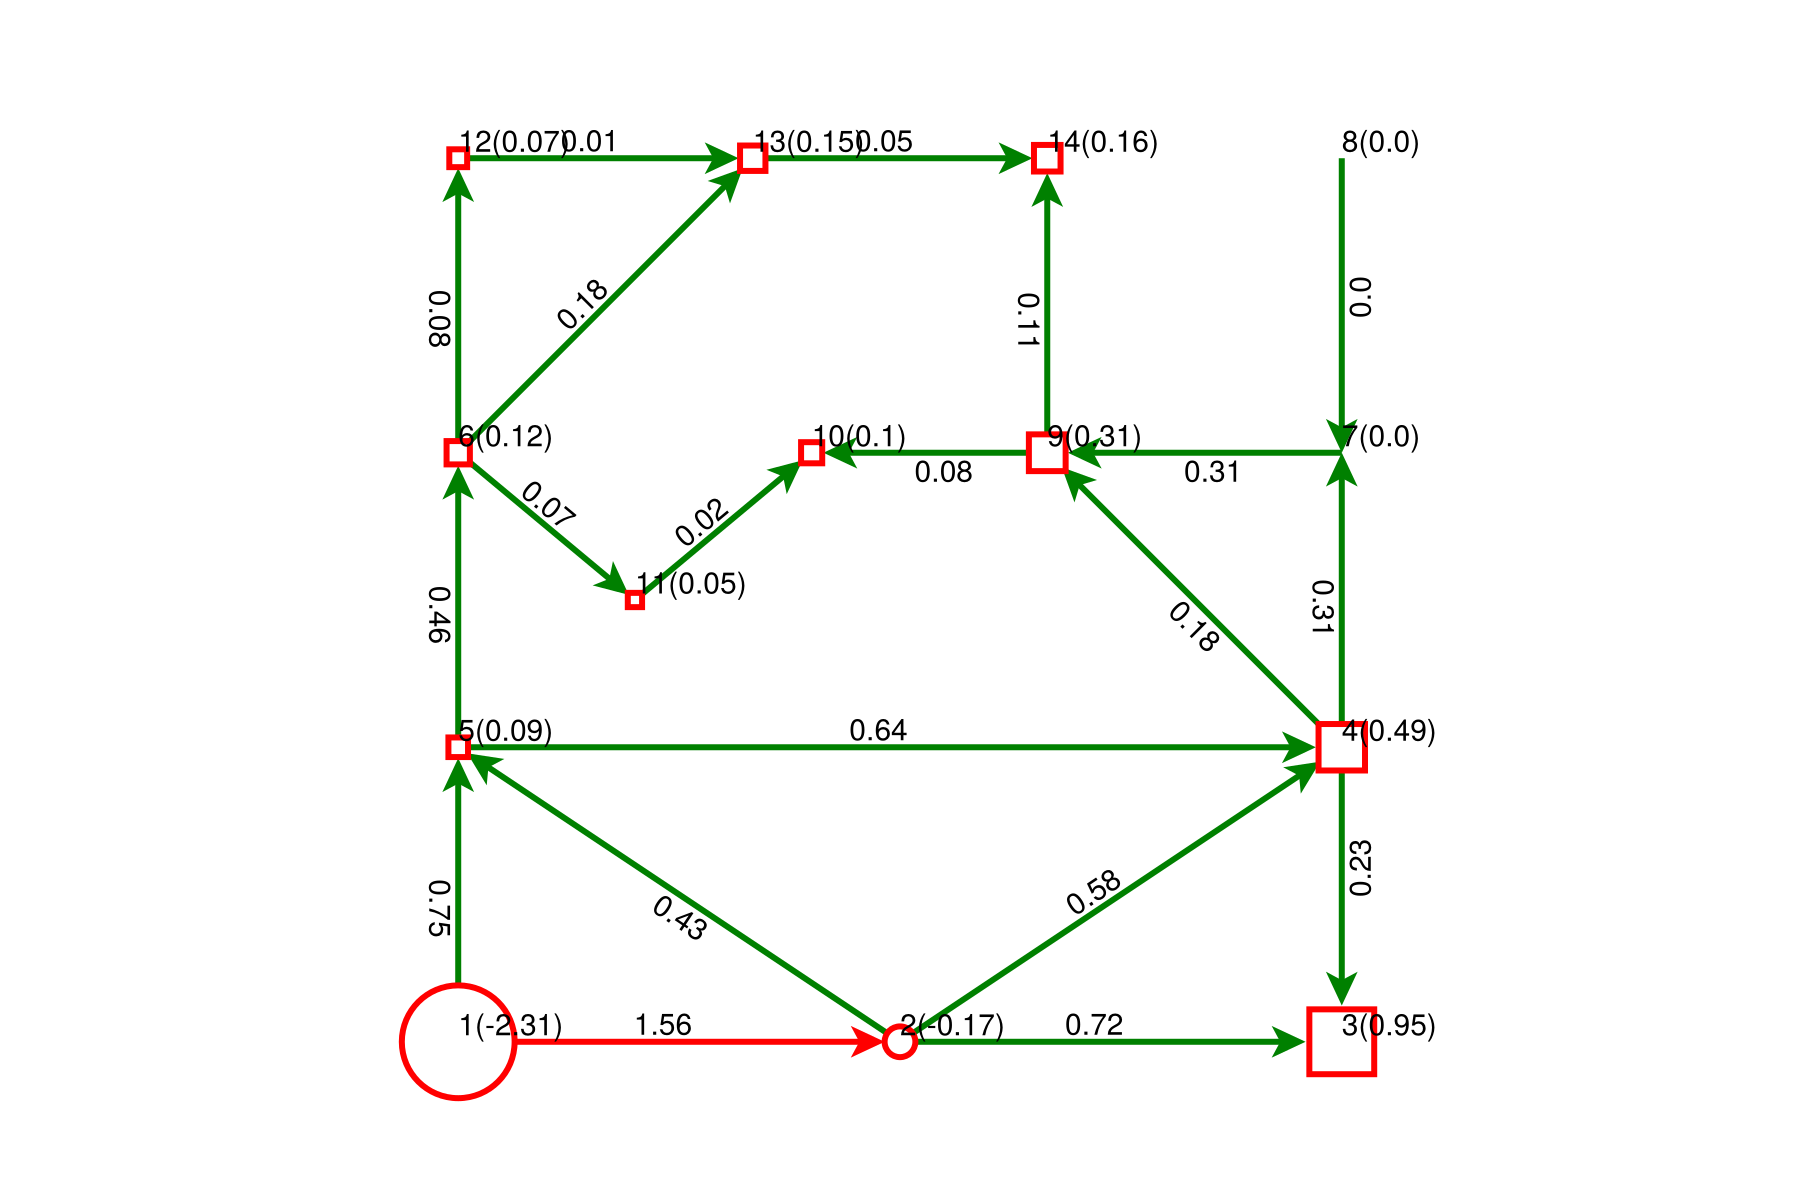

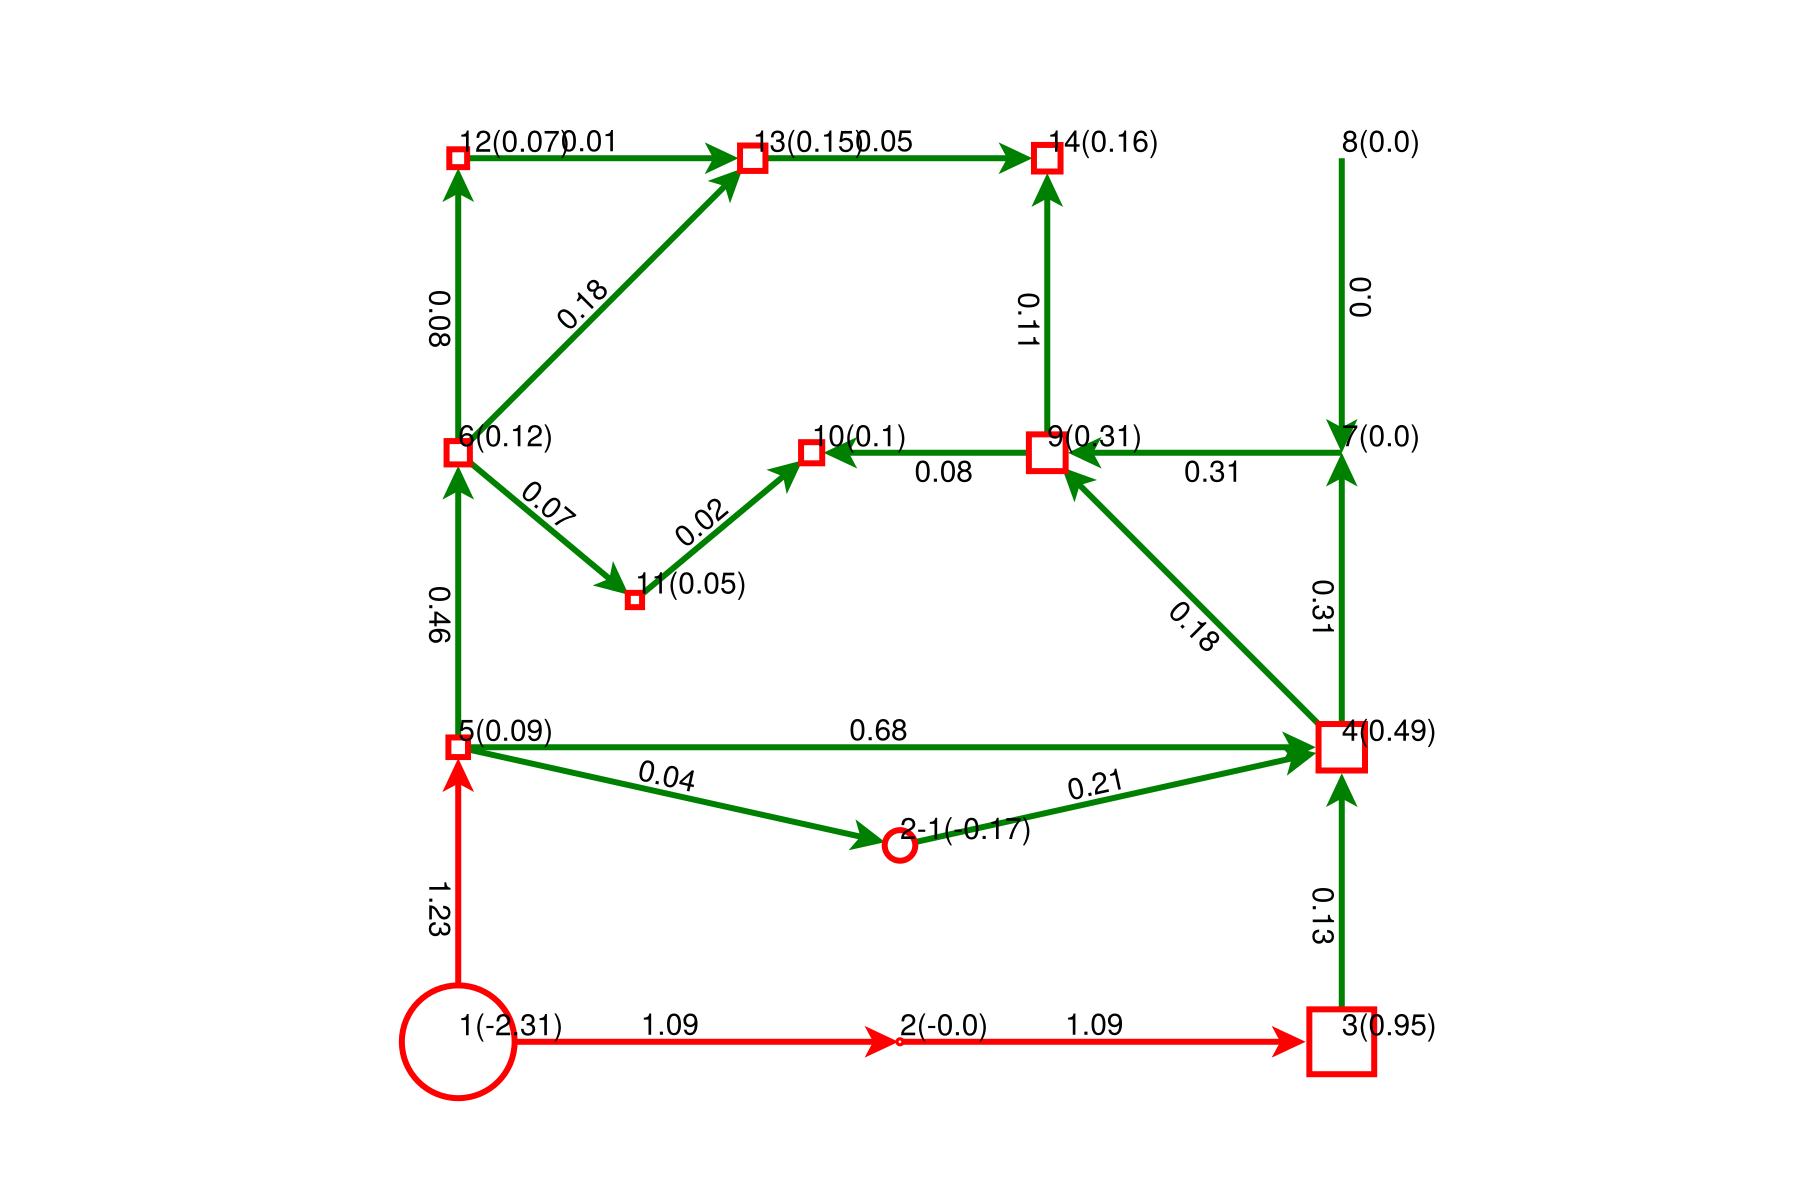

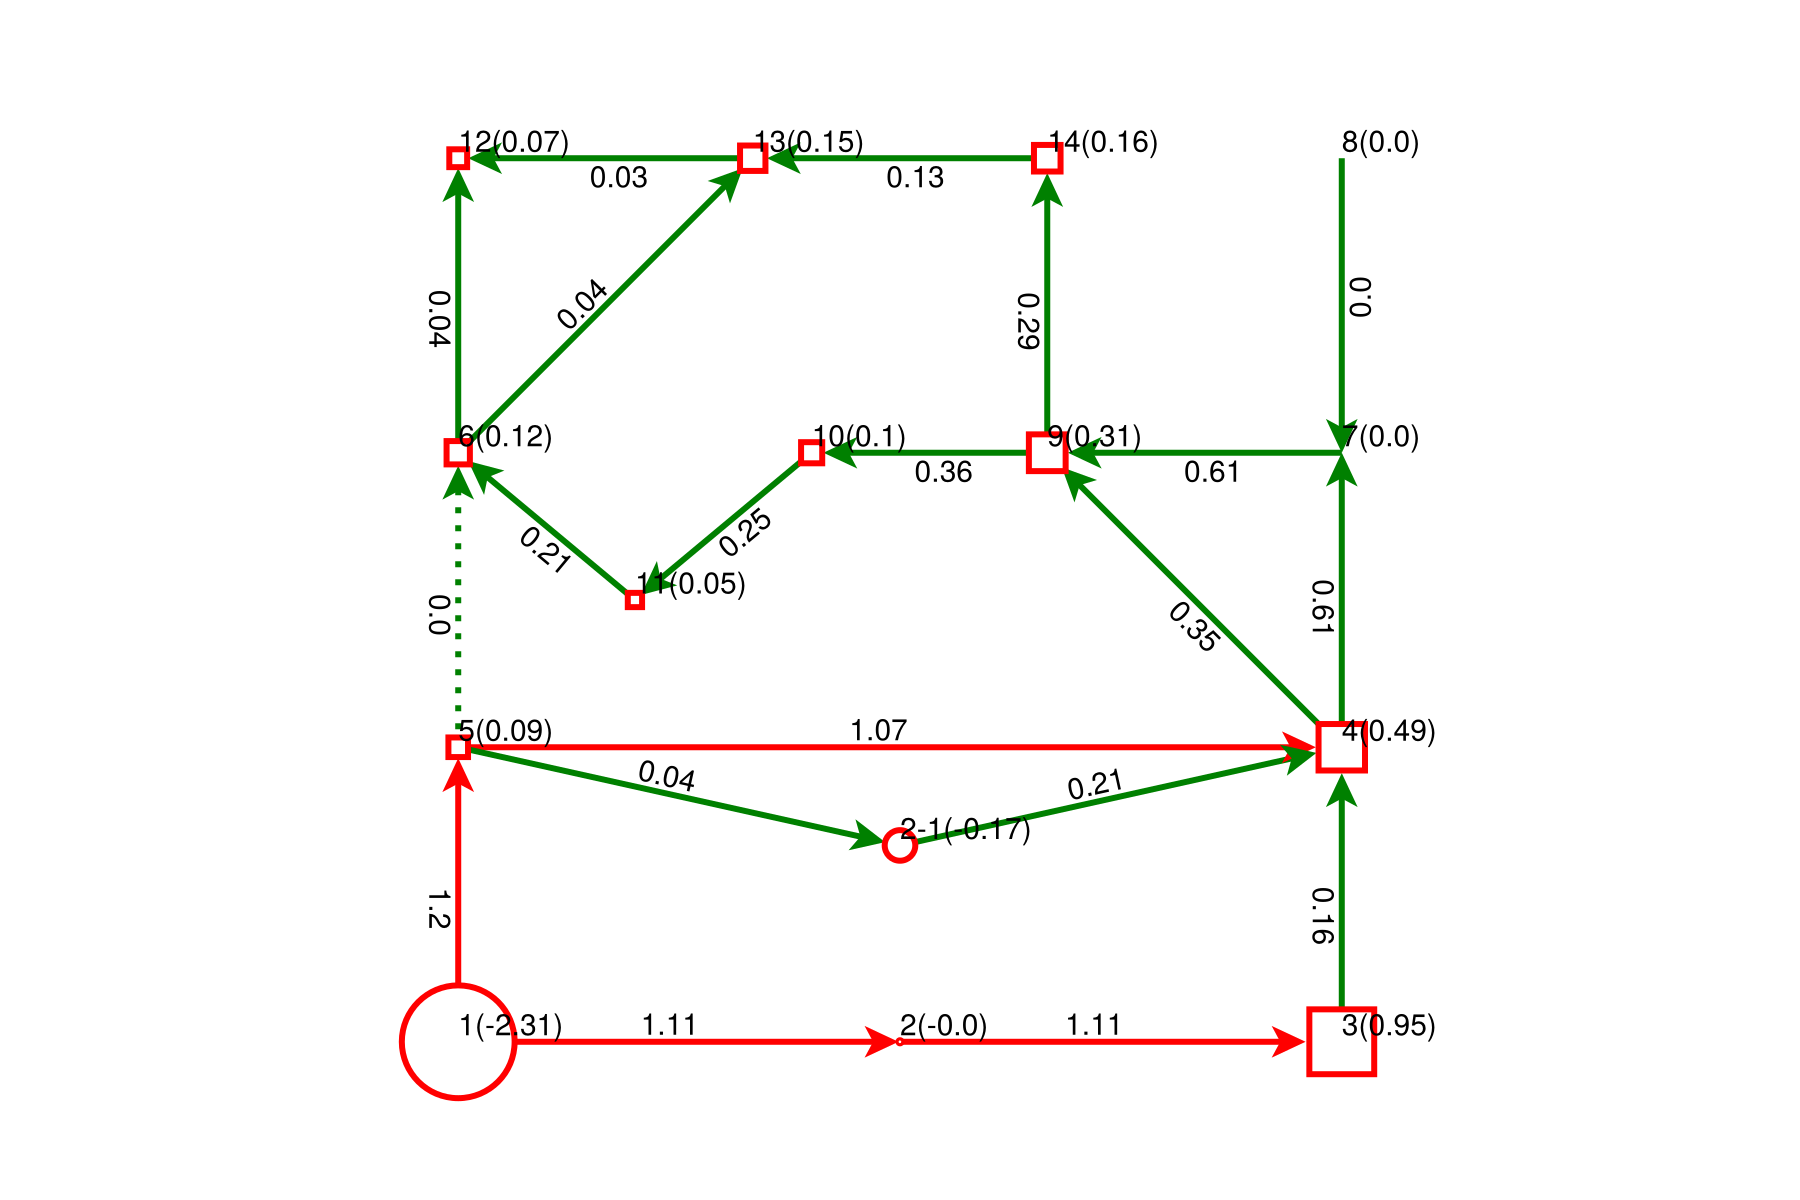

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27
Set parameter LogFile to value "my_log_file.txt"
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.1.0 23B81)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 465 rows, 180 columns and 1374 nonzeros
Model fingerprint: 0x29d34a87
Variable types: 159 continuous, 21 integer (21 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+02]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-16, 1e+02]
Presolve removed 229 rows and 79 columns
Presolve time: 0.01s
Presolved: 236 rows, 101 columns, 932 nonzeros
Variable types: 81 continuous, 20 integer (20 binary)
Found heuristic solution: objective 3.0128333

Root relaxation: objective 1.156434e+00, 113 iterations, 0.00 seconds (0.00 work un

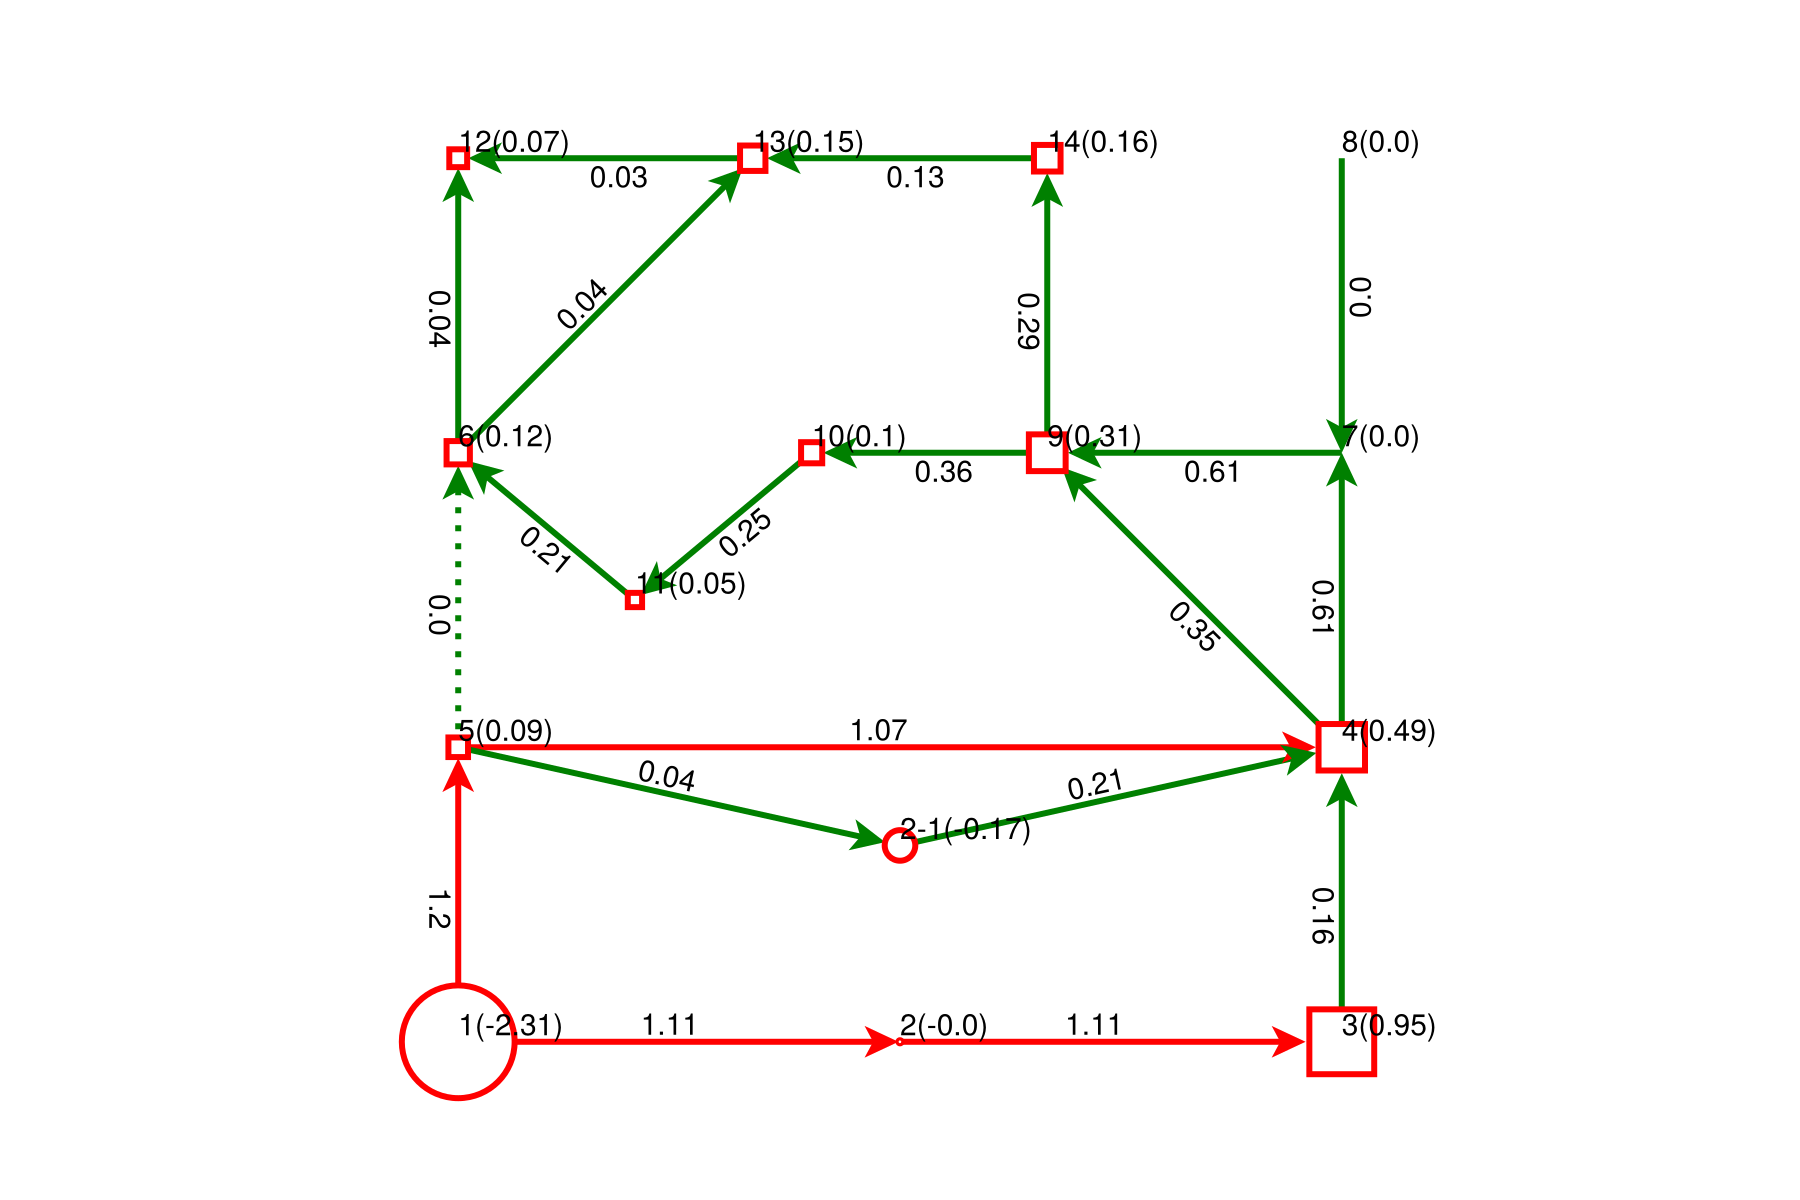

In [23]:
g, bus_confs, contingencies = create_case(sys)
# g, bus_confs, contingencies, coord = create_mini_case()
is_single_ρ = true
ρ_min_bound = 0.
n_1_connectedness = false
allow_branch_openings = true
# bus_confs = BusConf[]

model = secured_dc_OTS(g,
                # contingencies = contingencies,
                is_single_ρ=is_single_ρ,
                ρ_min_bound=ρ_min_bound,
                n_1_connectedness = n_1_connectedness,
                allow_branch_openings = allow_branch_openings,
                bus_confs = bus_confs,
                )
optimize!(model)

display("overload: $(value(model[:overload]))")

trip = nothing #12
openings = []

if allow_branch_openings
    openings = [i for (i,v_branch) in enumerate(value.(model[:v_branch])) if v_branch == 1]
    display("open:$openings")
    display([collect(edge_labels(g))[i] for i in openings])
end

applied_conf=BusConf[]
if bus_confs ≠ BusConf[]
    display("v_bus: $(value.(model[:v_bus]))")
    display("γ_bus: $(value.(model[:γ_bus]))")
    applied_conf = BusConf[bus_confs[i] for (i, v) in enumerate(value.(model[:v_bus])) if isapprox(v, 1, atol=1e-9)]
    display("applied_conf: $applied_conf")
end

g_base = dc_flow(g, trip = trip)
g_result=add_subBus(g, applied_conf)
dc_flow!(g_result, outages = openings)

play_openings = []
play_conf = bus_confs
g_play=add_subBus(g, play_conf)
play_trip = 1
dc_flow!(g_play, outages = play_openings, trip = play_trip)

layout = isa(coord, Dict{String, Point2}) ? coord : Stress(Ptype=Float32)

draw(g_base, trip = trip, layout = layout);#, fig_size = (1300,1300), font_size = 10)
draw(g_result , outages = openings, layout = layout);
draw(g_play , outages = play_openings, trip = play_trip, layout = layout);

# display(solution_summary(model))



In [24]:
filter_latex_formulation(model, "")

"\$\$ \\begin{aligned}\n\\min\\quad & 0.1 v\\_branch_{1} + 0.1 v\\_branch_{2} + 0.1 v\\_branch_{3} + 0.1 v\\_branch_{4} + 0.1 v\\_branch_{5} + 0.1 v\\_branch_{6} + 0.1 v\\_branch_{7} + 0.1 v\\_branch_{8} + 0.1 v\\_branch_{9} + 0.1 v\\_branch_{10} + 0.1 v\\_branch_{11} + 0.1 v\\_branch_{12" ⋯ 37668 bytes ⋯ "ch_{15} + c\\_w_{1,15,2} \\geq 0\\\\\n & -v\\_branch_{16} + c\\_w_{1,16,2} \\geq 0\\\\\n & -v\\_branch_{17} + c\\_w_{1,17,2} \\geq 0\\\\\n & -v\\_branch_{18} + c\\_w_{1,18,2} \\geq 0\\\\\n & -v\\_branch_{19} + c\\_w_{1,19,2} \\geq 0\\\\\n & -v\\_branch_{20} + c\\_w_{1,20,2} \\geq 0\\\\\n\\end{aligned} \$\$"

## Secured DC PF

$$ \rho^* = \arg\,\max_{\vec{\beta},\vec{u}}\, \min_{\rho}\rho\\
s.t.\\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})\vec{\beta}\\
|\vec{f}| \preceq \rho \overline{\vec{f}} \\
(1-\vec{u}) \odot \vec{\beta} = 0 \\
u_l \in \{0,1\} \\
\sum_l{u_l} \le 1

$$

$$ \rho^* = \arg\,\max_{\vec{w},\vec{u}, \vec{\beta},\rho}\, \rho \\
s.t. \\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})\vec{\beta} \\
|\vec{f}| \preceq (1-\vec{u})M \\
|\vec{f} - \rho \overline{\vec{f}}| \preceq (1-\vec{w})M\\
|\vec{\beta}| \preceq \vec{u}M \\
u_l \in \{0,1\} \\
\sum_l{u_l} \le 1
$$

$$
w_l \in \{0,1\} \qquad \forall l \\
\sum_{l}{w_l}=1
$$

In [25]:
function secured_dc_pf_optim_2(g)
    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)

    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)]) #TODO: check consistency
    B = A'*D*A
    B_inv = inv(Matrix(B + spdiagm(fill(1/nv(g), nv(g)))))
    p_to_f = D*A*B_inv
    δ_to_f = D - p_to_f*A'*D
    big_M = 100

    p = [g[label_for(g, v)] for v in vertices(g)]
    p_max = [e_index_for(g, e).p_max for e in edges(g)]
    
    @variable(model, flows[1:ne(g)])
    @variable(model, β[1:ne(g)])
    @variable(model, ρ)
    # @variable(model, 0 ≤ u[i=1:ne(g)] ≤ 1)
    @variable(model, u[1:ne(g)], Bin)
    @variable(model, w[1:ne(g)], Bin)
    # @variable(model, 0 ≤ w[i=1:ne(g)] ≤ 1)
    
    @constraint(model, c_flows , flows == p_to_f * p + δ_to_f * β)

    @constraint(model,  flows ≤ ρ.*p_max)
    @constraint(model, -flows ≤ ρ.*p_max)
    
    @constraint(model,  flows .≤ big_M.*(1 .- u))
    @constraint(model, -flows .≤ big_M.*(1 .- u))
    
    @constraint(model, ρ .- flows .≤ big_M.*(1 .- w))
    @constraint(model, flows .- ρ .≤ big_M.*(1 .- w))

    @constraint(model,  β ≤ big_M .* u)
    @constraint(model, -β ≤ big_M .* u)

    @constraint(model, sum_u, sum(u) == 1)
    @constraint(model, sum_w, sum(w) == 1)

    @objective(model, Max, ρ)
    model
end

secured_dc_pf_optim_2 (generic function with 1 method)

In [26]:
sys = System(joinpath("data", "case118.m"))
# sys = System(joinpath("data", "case1354pegase.m"))
g = network2graph(sys)
add_constraint(g, b->b.p_max=1)

┌ Info: Correcting vm in bus 19 to 0.962 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: Correcting vm in bus 32 to 0.963 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: Correcting vm in bus 34 to 0.984 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: Correcting vm in bus 92 to 0.99 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: Correcting vm in bus 103 to 1.01 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: this code only supports angmin values in -90 deg. to 90 deg., tightening the value on branch 1 from -360.0 t

In [27]:
model = secured_dc_pf_optim_2(g)
optimize!(model)
# display(latex_formulation(model))
println(value(model[:ρ]))
println(value.(model[:u]))
println(value.(model[:w]))
# println(value.(model[:flows]))
print(solution_summary(model))

4.823535445870746
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

## Secured DC OTS


$$ \rho^* = \arg\,\min_{v, \vec{\gamma}}\,\max_{\vec{\beta},\vec{u}}\rho\\
s.t.\\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})(\vec{\beta} + \vec{\gamma})\\
|\vec{f}| \preceq \rho \overline{\vec{f}} \\
(1-\vec{u}) \odot \vec{\beta} = 0 \\
(1-\vec{v}) \odot \vec{\gamma} = 0 \\
u_l \in \{0,1\} \\
\sum_l{u_l} \le 1
v_l \in \{0,1\} \qquad \forall l \\
$$

$$ \rho^* = \arg\,\min_{\vec{v}, \vec{\gamma}} \max_{\vec{w},\vec{u}, \vec{\beta},\rho}\, \rho \\
s.t. \\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})(\vec{\beta} + \vec{\gamma}) \\
|\vec{f}| \preceq (1-\vec{u})M \\
|\vec{f}| \preceq (1-\vec{v})M \\
|\vec{f} - \rho \overline{\vec{f}}| \preceq (1-\vec{w})M\\
|\vec{\beta}| \preceq \vec{u}M \\
|\vec{\gamma}| \preceq \vec{v}M \\
u_l \in \{0,1\} \qquad \forall l \\
\sum_l{u_l} \le 1
$$

$$
w_l \in \{0,1\} \qquad \forall l \\
\sum_{l}{w_l}=1 \\
v_l \in \{0,1\} \qquad \forall l \\
$$

In [28]:
function secured_dc_ots(g)
    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)

    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)]) #TODO: check consistency
    B = A'*D*A
    B_inv = inv(Matrix(B + spdiagm(fill(1/nv(g), nv(g)))))
    p_to_f = D*A*B_inv
    δ_to_f = D - p_to_f*A'*D
    big_M = 100

    p = [g[label_for(g, v)] for v in vertices(g)]
    p_max = [e_index_for(g, e).p_max for e in edges(g)]
    
    @variable(model, flows[1:ne(g)])
    @variable(model, β[1:ne(g)])
    @variable(model, γ[1:ne(g)])
    @variable(model, ρ)
    # @variable(model, 0 ≤ u[i=1:ne(g)] ≤ 1)
    @variable(model, u[1:ne(g)], Bin)
    @variable(model, v[1:ne(g)], Bin)
    @variable(model, w[1:ne(g)], Bin)
    # @variable(model, 0 ≤ w[i=1:ne(g)] ≤ 1)
    
    @constraint(model, c_flows , flows == p_to_f * p + δ_to_f * (β + γ))

    @constraint(model,  flows ≤ ρ.*p_max)
    @constraint(model, -flows ≤ ρ.*p_max)
    
    @constraint(model,  flows .≤ big_M.*(1 .- u))
    @constraint(model, -flows .≤ big_M.*(1 .- u))
    
    @constraint(model,  flows .≤ big_M.*(1 .- v))
    @constraint(model, -flows .≤ big_M.*(1 .- v))
    
    @constraint(model, ρ .- flows .≤ big_M.*(1 .- w))
    @constraint(model, flows .- ρ .≤ big_M.*(1 .- w))

    @constraint(model,  β ≤ big_M .* u)
    @constraint(model, -β ≤ big_M .* u)

    @constraint(model,  γ ≤ big_M .* v)
    @constraint(model, -γ ≤ big_M .* v)

    @constraint(model, sum_u, sum(u) == 1)
    @constraint(model, sum_w, sum(w) == 1)

    @objective(model, Max, ρ)
    model
end

secured_dc_ots (generic function with 1 method)

# Work in progress

$$
\max_{\vec{\beta}, \vec{u}}{\rho} \\
\begin{split}
    \vec{g} = \vec{f} -\mathbf{DA}\mathbf{\hat{B}}^{-1}\vec{p} - (\mathbf{D} -\mathbf{DA}\mathbf{\hat{B}}^{-1}\mathbf{A}^T\mathbf{D})(\vec{\beta} + \mathbf{T}\vec{\gamma}) & \rightarrow \vec{\nu} \\
    \vec{f} - (1-\vec{u})M \preceq 0 & \rightarrow \vec{\lambda_{f pos}}\\
    - \vec{f} - (1-\vec{u})M \preceq 0 & \rightarrow  \vec{\lambda_{f neg}}\\
    \vec{\beta} - \vec{u}M \preceq 0 & \rightarrow  \vec{\lambda_{\beta pos}}\\
    -\vec{\beta} - \vec{u}M \preceq 0 & \rightarrow \vec{\lambda_{\beta neg}}\\
    \vec{u} -1 \preceq 0 \ & \rightarrow \vec{\lambda_{u pos}} \\
    -\vec{u} \preceq 0 \ l & \rightarrow  \vec{\lambda_{u neg}} \\
    -1 + \sum_l{u_l} \le 0 & \rightarrow  \lambda_{u sum}
\end{split}
$$

It is a LP, for which the dual function is known.
$$
\max_{\vec{x}} \vec{c} \odot \vec{x} \\
s.t. \\
\mathbf{A} \vec{x} = \vec{b} \\
\vec{x} \preceq 0
$$

Dual
$$
\min_{\vec{\nu}, \vec{\lambda}} -\vec{b} \odot \vec{x} \\
s.t. \\
\vec{c} + \vec{\lambda} + \mathbf{A}^T\vec{\nu} = 0 \\
\vec{\lambda} \succeq 0
$$


